In [ ]:
# Install conda
!pip install -q condacolab
import condacolab
condacolab.install()
# Install astra-toolbox
!conda install -c astra-toolbox astra-toolbox
# Install odl
!pip3 install https://github.com/odlgroup/odl/archive/master.zip

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:18
🔁 Restarting kernel...
Channels:
 - astra-toolbox
 - conda-forge
Platform: linux-64
Solving environment: - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - astra-toolbox


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    astra-toolbox-2.1.3        |  py310hb150abf_0         539 KB  astra-toolbox
    ca-certificates-2024.2.2   |       hbcca054_0         152 KB  conda-forge
    certifi-2024.2.2           |     pyhd8ed1ab_0         157 KB  con

In [ ]:
import odl
import astra
astra.test()

ASTRA Toolbox v2.1.3
Getting GPU info... GPU #0: Tesla T4, with 15102MB, CUDA compute capability 7.5
Testing basic CPU 2D functionality... Ok
Testing basic CUDA 2D functionality... Ok
Testing basic CUDA 3D functionality... Ok


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import os
import numpy as np

In [ ]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
img_size, space_range = 512, 128 #space discretization
num_angles, det_shape = 200, 400 #projection parameters
noise_std_dev = 10

space = odl.uniform_discr([-space_range, -space_range], [space_range, space_range],(512,512), dtype='float32', weighting=1.0)
geometry = odl.tomo.geometry.parallel.parallel_beam_geometry(space, num_angles=num_angles, det_shape=det_shape)
fwd_op_odl = odl.tomo.RayTransform(space, geometry,impl='astra_cuda')
opnorm  =1
#opnorm = odl.power_method_opnorm(fwd_op_odl)
rt = (1 / opnorm) * fwd_op_odl
fbp_op_odl = odl.tomo.fbp_op(fwd_op_odl)

import odl.contrib.torch as odl_torch
A = odl_torch.OperatorModule(rt).to(device)
adjA = odl_torch.OperatorModule(rt.adjoint).to(device)
fbp = odl_torch.OperatorModule(fbp_op_odl).to(device)

In [ ]:
num_parts =  # Number of partitions

space = odl.uniform_discr([-space_range, -space_range], [space_range, space_range], (512, 512), dtype='float32', weighting=1.0)
dpart = geometry.det_partition

matrix = np.array([[1, 0],
                   [0, 1]])

sub_fwdop = []
sub_invop = []

for i in range(num_parts):
    apart = odl.uniform_partition(0 + i * np.pi / num_parts, np.pi / num_parts + i * np.pi / num_parts, num_angles//num_parts)
    geom = geometry.frommatrix(apart, dpart, matrix)
    sampled_fwd_op = odl.tomo.RayTransform(space, geom, impl='astra_cuda')
    opnorm1 = 1
    #opnorm1 = odl.power_method_opnorm(sampled_fwd_op)
    rayt = (1 / opnorm1) * sampled_fwd_op
    subA = odl_torch.OperatorModule(rayt).to(device)
    subadjA = odl_torch.OperatorModule(rayt.adjoint).to(device)
    sub_fwdop.append(subA)
    sub_invop.append(subadjA)

In [ ]:
import torch
import torch.nn as nn

class dual_net(nn.Module):
    def __init__(self, n_in_channels=3, n_out_channels = 1, n_filters=32, kernel_size=5):
        super(dual_net, self).__init__()
        self.pad = (kernel_size-1)//2
        self.conv1 = nn.Conv2d(n_in_channels, out_channels=n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv3 = nn.Conv2d(n_filters, out_channels=1, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)

        self.act1 = nn.PReLU(num_parameters=1, init=0.25)
        self.act2 = nn.PReLU(num_parameters=1, init=0.25)


    def forward(self, h, y, z):
        dh = torch.cat((h, y, z), dim=1)
        dh = self.act1(self.conv1(dh))
        dh = self.act2(self.conv2(dh))
        dh = self.conv3(dh)
        return h + dh

class primal_net(nn.Module):
    def __init__(self, n_in_channels=2, n_out_channels = 1, n_filters=32, kernel_size=5):
        super(primal_net, self).__init__()
        self.pad = (kernel_size-1)//2
        self.conv1 = nn.Conv2d(n_in_channels, out_channels=n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)
        self.conv3 = nn.Conv2d(n_filters, out_channels=1, kernel_size=kernel_size, stride=1, padding=self.pad, bias=True)

        self.act1 = nn.PReLU(num_parameters=1, init=0.25)
        self.act2 = nn.PReLU(num_parameters=1, init=0.25)

    def forward(self, x, u):
        dx = torch.cat((x, u), dim=1)
        dx = self.act1(self.conv1(dx))
        dx = self.act2(self.conv2(dx))
        dx = self.conv3(dx)
        return x + dx

class LSPD(nn.Module):
    def __init__(self, fwd_op, adjoint_op, num_nets=20, sigma=0.01, tau=0.01):
        super(LSPD, self).__init__()

        self.fwd_op = fwd_op
        self.adjoint_op = adjoint_op
        self.num_nets = num_nets
        self.sigma = nn.Parameter(sigma * torch.ones(self.num_nets).to(device))
        self.tau = nn.Parameter(tau * torch.ones(self.num_nets).to(device))
        self.primal_net = nn.ModuleList([primal_net().to(device) for i in range(self.num_nets)])
        self.dual_net = nn.ModuleList([dual_net().to(device) for i in range(self.num_nets)])

    def forward(self, y, x_init,num_partitions=num_parts):
        x = x_init  #primal variable

        sub_y = []
        part_width = y.shape[2]//num_partitions
        for i in range(num_partitions):
          start_x = i * part_width
          end_x = (i + 1) * part_width
          part = y[:,:, start_x:end_x,:]
          sub_y.append(part)
        h = torch.zeros_like(sub_y[0]) #dual variable
        for i in range(self.num_nets):
            h = self.dual_net[i](h, sub_y[i%num_partitions], self.sigma[i] * self.fwd_op[i%num_partitions](x))
            x = self.primal_net[i](x, self.tau[i] * self.adjoint_op[i%num_partitions](h))
        return x

net = LSPD(fwd_op = sub_fwdop,adjoint_op=sub_invop).to(device)

In [ ]:
class CT_Dataset(Dataset):
    def __init__(self, ground_truths):
        self.ground_truths = ground_truths

    def __len__(self):
        return len(self.ground_truths)

    def __getitem__(self, index):
        ground_truth = self.ground_truths[index]
        return ground_truth

In [ ]:
from multiprocessing import Pool

folder_path = "/content/drive/MyDrive/mayo_data"
file_list = [f for f in os.listdir(folder_path) if f.endswith('.npy')]

def load_data(file_name):
    file_path = os.path.join(folder_path, file_name)
    data = np.load(file_path)
    return data

num_processes = os.cpu_count()
data_list = []
with Pool(processes=num_processes) as pool:
    for data in pool.imap_unordered(load_data, file_list):
        if(len(data_list)) >= 256:
          break
        data_list.append(data)


from torchvision import transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

tensor_list = [transform(img) for img in data_list]

train_size = int(0.8*len(tensor_list))
train_dataset = CT_Dataset(tensor_list[:train_size])
test_dataset = CT_Dataset(tensor_list[train_size:])

In [ ]:
import torch.optim as optim

start_epoch=0
end_epoch=15

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(),lr = 5e-5, betas=(0.5, 0.99))

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

def validator(testloader, net):
    net.eval()
    total_loss = 0.0
    with torch.no_grad():
        for ground_truths in testloader:
            ground_truths = ground_truths.to(device)
            measurements = (A(ground_truths)).to(device)
            measurements = measurements+noise_std_dev * torch.randn_like(measurements).to(device)
            x_init = fbp(measurements).to(device)
            outputs = net(y = measurements, x_init= x_init)
            loss = criterion(outputs, ground_truths)
            total_loss += loss.item()

    avg_loss = total_loss / len(testloader)
    return avg_loss

In [ ]:
your_google_drive_path = '/content/drive/MyDrive/btp_models/'
#If you are resuming your model, Uncomment following lines

# checkpoint = torch.load(your_google_drive_path+'checkpoint_LSPD.pth')
# start_epoch = checkpoint['epoch']+1
# net.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
import time

best_loss = float('inf')
BATCH_SIZE = 1 # Adjust as needed

for epoch in range(start_epoch, end_epoch):
    start_time = time.time()

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    for i, (ground_truths) in enumerate(train_dataloader, 0):
        ground_truths = ground_truths.to(device)
        measurements = (A(ground_truths)).to(device)
        measurements = measurements+noise_std_dev * torch.randn_like(measurements).to(device)
        x_init = fbp(measurements).to(device)

        optimizer.zero_grad()
        outputs = net(y = measurements, x_init = x_init)
        loss = criterion(outputs, ground_truths)
        loss.backward()
        optimizer.step()

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f"Epoch: {epoch}, Loss: {loss}, Time: {epoch_time} seconds")

    # Validate the model and save if it's the best model
    current_test_loss = validator(test_dataloader, net)
    if current_test_loss < best_loss:
      best_loss = current_test_loss
      torch.save(
          {'epoch':epoch,
          'model_state_dict': net.state_dict(),
          'optimizer_state_dict': optimizer.state_dict()
          },
          your_google_drive_path+'best_model_LSPD.pth')

    torch.save(
        {'epoch':epoch,
         'model_state_dict': net.state_dict(),
         'optimizer_state_dict': optimizer.state_dict()
         },
         your_google_drive_path+'checkpoint_LSPD.pth')

print('Finished Training')


Epoch: 0, Loss: 12788.28125, Time: 163.61349725723267 seconds
Epoch: 1, Loss: 11672.1796875, Time: 167.10685896873474 seconds
Epoch: 2, Loss: 25690.474609375, Time: 167.43546319007874 seconds
Epoch: 3, Loss: 11629.0791015625, Time: 167.67815160751343 seconds
Epoch: 4, Loss: 8166.0947265625, Time: 167.25999879837036 seconds
Epoch: 5, Loss: 11641.560546875, Time: 166.72656083106995 seconds
Epoch: 6, Loss: 12819.9072265625, Time: 167.41953682899475 seconds
Epoch: 7, Loss: 10547.76171875, Time: 166.81088042259216 seconds


KeyboardInterrupt: 

In [ ]:
# Load the model
model_path = '/content/drive/MyDrive/btp_models/best_model_LSPD.pth'
loaded_model = LSPD(fwd_op = sub_fwdop,adjoint_op=sub_invop).to(device)
checkpoint = torch.load(model_path)
loaded_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

In [ ]:
from math import log10, sqrt
def psnr(original, compressed):
    original = original.cpu().detach().numpy() if torch.is_tensor(original) else original
    compressed = compressed.cpu().detach().numpy() if torch.is_tensor(compressed) else compressed
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return 100
    max_pixel = 1.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [ ]:
import torch
import torch.nn.functional as F

def ssim(img1, img2, window_size=9, size_average=True):
    # Ensure both images have the same size
    assert img1.shape == img2.shape, "Images must have the same dimensions"

    # Define a Gaussian kernel for window weights
    channel = img1.shape[1]
    window = torch.Tensor([[[[0.03797616, 0.044863533, 0.03797616],
                             [0.044863533, 0.053, 0.044863533],
                             [0.03797616, 0.044863533, 0.03797616]]]]).repeat(channel, 1, 1, 1)
    window = window.to(img1.device)

    # Compute local means
    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

    # Compute local variances and covariances
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    # Compute SSIM components
    c1 = (0.01 * 255) ** 2
    c2 = (0.03 * 255) ** 2
    ssim_map = ((2 * mu1_mu2 + c1) * (2 * sigma12 + c2)) / ((mu1_sq + mu2_sq + c1) * (sigma1_sq + sigma2_sq + c2))

    # Average SSIM within window
    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)  # Return the average over channels, batch, and spatial dimensions

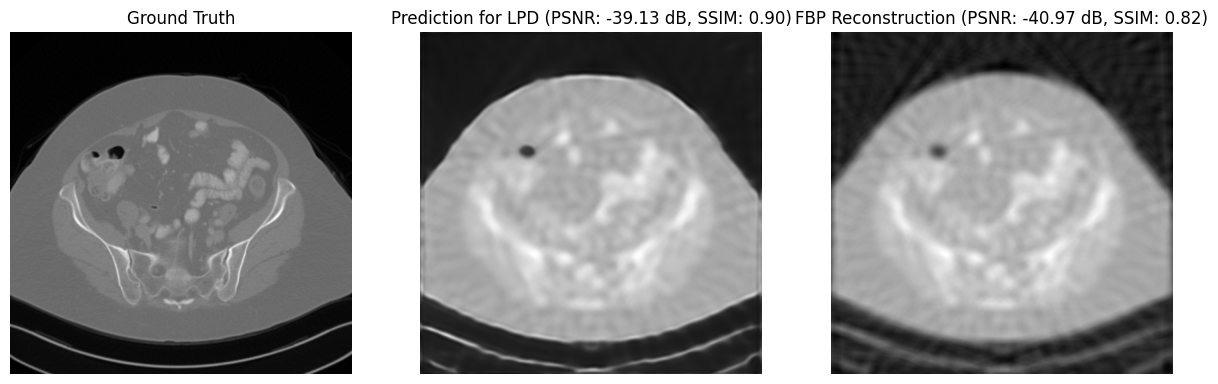

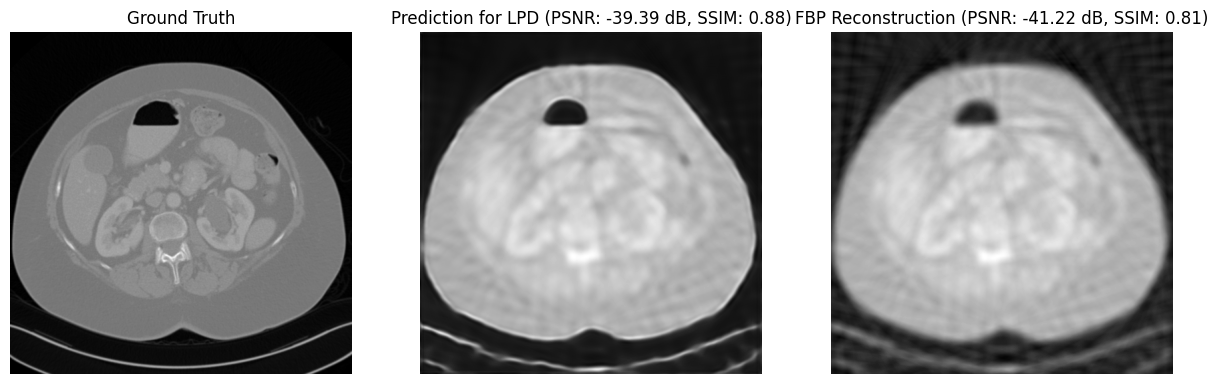

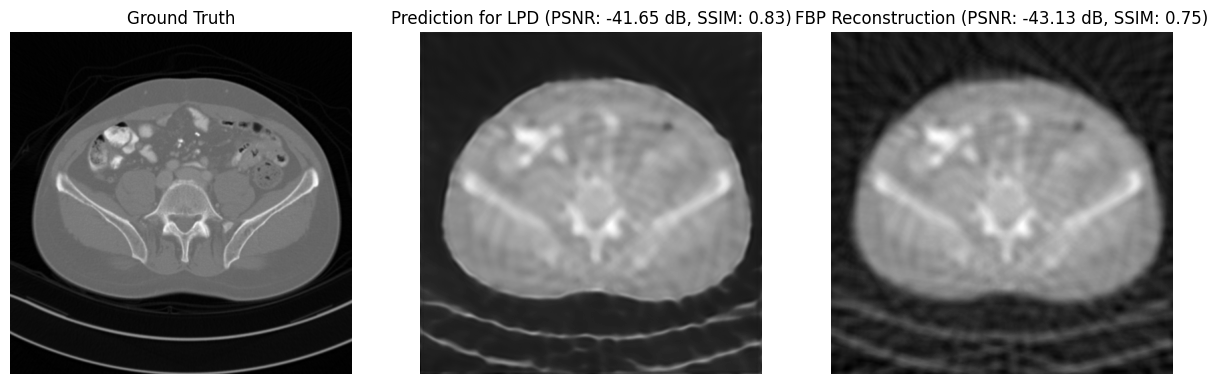

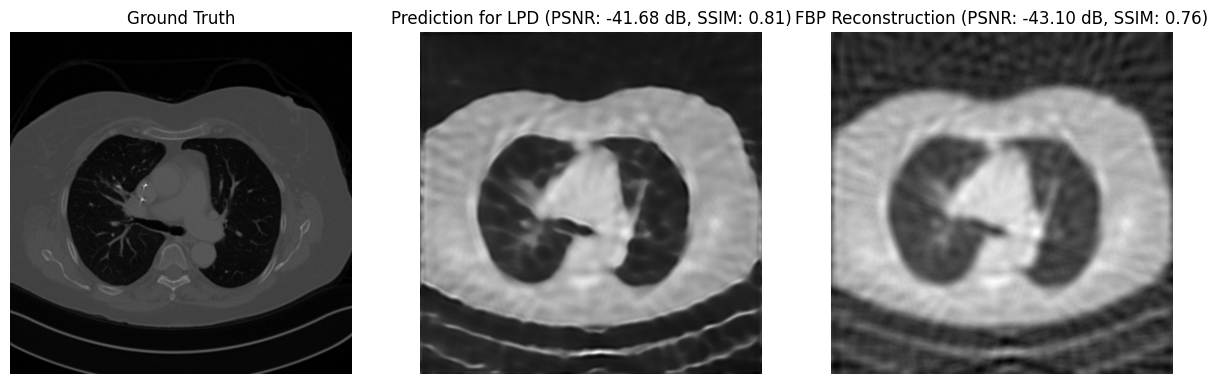

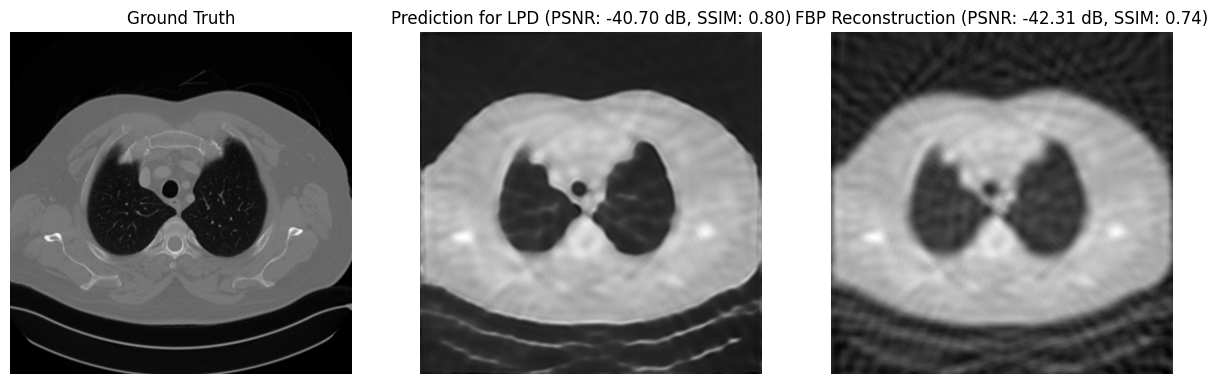

Average PSNR for LPD: -40.51 dB
Average PSNR for FBP: -42.15 dB


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Set the model to evaluation mode
loaded_model.eval()

# Number of samples to visualize and calculate PSNR and SSIM
num_samples = 5

psnr_values = []
psnr_fbp_values = []
ssim_values = []
ssim_fbp_values = []

newtest_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)

with torch.no_grad():  # No need to calculate gradients during testing
    for _ in range(num_samples):

        idx = np.random.randint(len(newtest_dataloader))
        batch_ground_truths = newtest_dataloader.dataset[idx]

        batch_ground_truths = batch_ground_truths.to(device)

        measurements = (A(batch_ground_truths)).to(device)
        measurements = measurements + noise_std_dev * torch.randn_like(measurements).to(device)
        x_fbp_batch = fbp(measurements).to(device)
        batch_measurements = measurements.unsqueeze(0)
        x_fbp_batch = x_fbp_batch.unsqueeze(0)
        batch_outputs = loaded_model(y=batch_measurements, x_init=x_fbp_batch)

        psnr_val = psnr(batch_ground_truths, batch_outputs)
        ssim_val = ssim(batch_outputs, batch_ground_truths.unsqueeze(1))
        psnr_values.append(psnr_val)
        ssim_values.append(ssim_val)
        psnr_fbp = psnr(batch_ground_truths, x_fbp_batch)
        ssim_fbp = ssim(x_fbp_batch, batch_ground_truths.unsqueeze(1))
        psnr_fbp_values.append(psnr_fbp)
        ssim_fbp_values.append(ssim_fbp)
        batch_ground_truths_np = batch_ground_truths.squeeze().cpu().numpy()
        batch_outputs_np = batch_outputs.squeeze().cpu().numpy()
        x_fbp_batch_np = x_fbp_batch.squeeze().cpu().numpy()
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(batch_ground_truths_np, cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(batch_outputs_np, cmap='gray')
        plt.title('Prediction for LPD (PSNR: {:.2f} dB, SSIM: {:.2f})'.format(psnr_val,ssim_val))
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(x_fbp_batch_np, cmap='gray')
        plt.title('FBP Reconstruction (PSNR: {:.2f} dB, SSIM: {:.2f})'.format(psnr_fbp,ssim_fbp))
        plt.axis('off')

        plt.show()

average_psnr = np.mean(psnr_values)
average_psnr_fbp = np.mean(psnr_fbp_values)
print('Average PSNR for LPD: {:.2f} dB'.format(average_psnr))
print('Average PSNR for FBP: {:.2f} dB'.format(average_psnr_fbp))

In [ ]:
print(f"ssim loss for fbp: {ssim(batch_ground_truths.unsqueeze(1),x_fbp_batch)}, for lpd: {ssim(batch_ground_truths.unsqueeze(1),batch_outputs)}")

ssim loss for fbp: 0.6759509444236755, for lpd: 0.7880512475967407


In [ ]:
del ground_truths
del measurements
del x_init
torch.cuda.empty_cache()